In [5]:
# Basic imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import f1_score, accuracy_score

from xgboost import XGBClassifier

# Keras imports

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.metrics import Accuracy
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [6]:
data = []
with open('/Users/lakshikajain/Documents/GitHub/datascience/ultimate_challenge/ultimate_data_challenge.json') as top_symbols:
    data = json.load(top_symbols)

In [9]:
users = pd.DataFrame(data)

In [11]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [13]:
users.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [15]:
users.signup_date = pd.to_datetime(users.signup_date)
users.last_trip_date = pd.to_datetime(users.last_trip_date)
users.city = users.city.astype('category')
users.phone = users.phone.astype('category')

In [17]:
users.last_trip_date.max()

Timestamp('2014-07-01 00:00:00')

In [19]:
users['active'] = users.last_trip_date >= '2014-06-01 00:00:00'

In [23]:
num_users = users.shape[0]
active_rate = users.active.sum() / num_users
active_rate

0.37608

/var/folders/g1/qd1tw3791flfg75j960ycnhc0000gn/T/ipykernel_71800/4059581368.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  city_active = users.groupby('city').active.sum() / users.groupby('city').active.count()


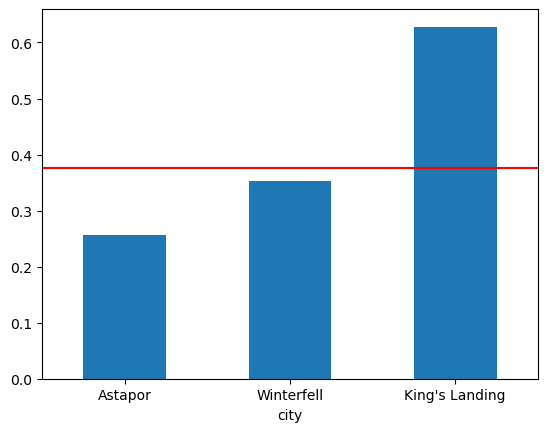

In [25]:
city_active = users.groupby('city').active.sum() / users.groupby('city').active.count()
city_active.nsmallest().plot(kind='bar')
plt.axhline(active_rate, c='r')
_ = plt.xticks(rotation=0)

/var/folders/g1/qd1tw3791flfg75j960ycnhc0000gn/T/ipykernel_71800/566829067.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  phone_active = users.groupby('phone').active.sum() / users.groupby('phone').active.count()


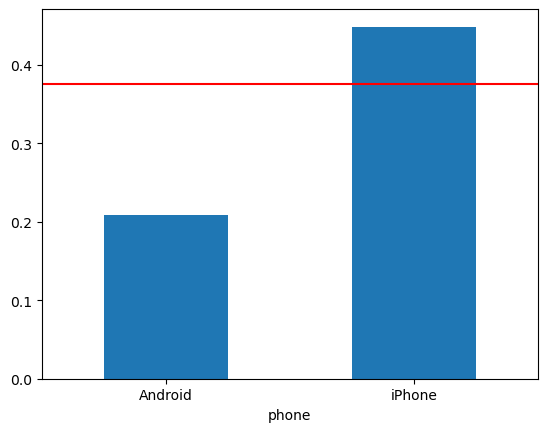

In [27]:
phone_active = users.groupby('phone').active.sum() / users.groupby('phone').active.count()
phone_active.nsmallest().plot(kind='bar')
plt.axhline(active_rate, c='r')
_ = plt.xticks(rotation=0)

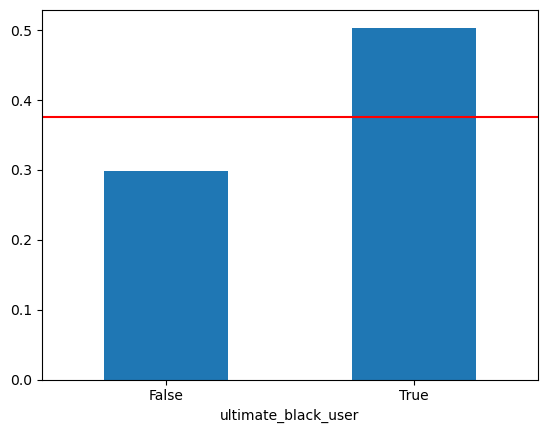

In [29]:
ultimate_black_active = users.groupby('ultimate_black_user').active.sum() / users.groupby('ultimate_black_user').active.count()
ultimate_black_active.nsmallest().plot(kind='bar')
plt.axhline(active_rate, c='r')
_ = plt.xticks(rotation=0)

/var/folders/g1/qd1tw3791flfg75j960ycnhc0000gn/T/ipykernel_71800/2278804683.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trips = users.groupby(pd.cut(users.trips_in_first_30_days, bins=bins))


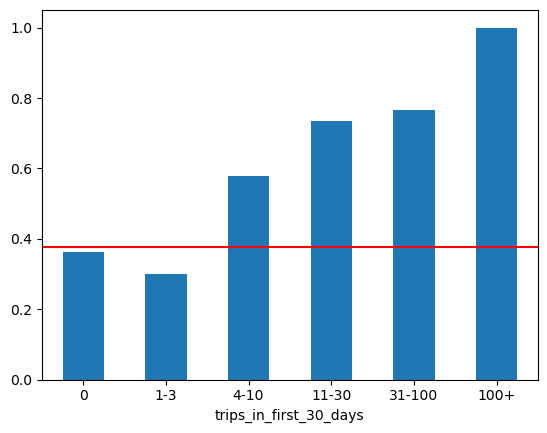

In [31]:
# Going by the number of trips after registration, the more trips a user take, the more likely they will be active. 

bins = pd.IntervalIndex.from_tuples([(-1, 0), (0, 3), (3, 10), (10, 30), (30, 100), (100, 200)])
trips = users.groupby(pd.cut(users.trips_in_first_30_days, bins=bins))

trips_active = trips.active.sum() / trips.active.count()
trips_active.plot(kind='bar')
plt.axhline(active_rate, c='r')
_ = plt.xticks(np.arange(6), ['0', '1-3', '4-10', '11-30', '31-100', '100+'], rotation=0)

/var/folders/g1/qd1tw3791flfg75j960ycnhc0000gn/T/ipykernel_71800/1229665162.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  distance = users.groupby(pd.cut(users.avg_dist, bins=bins))


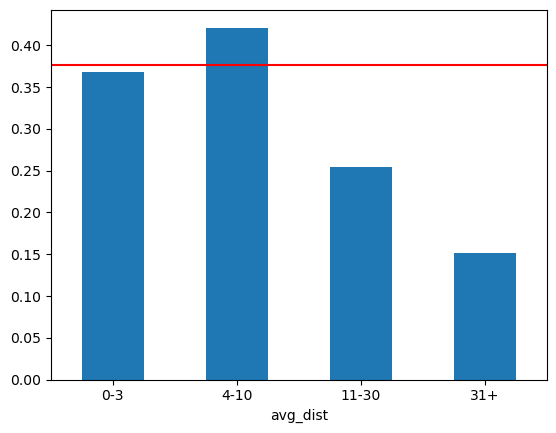

In [33]:
bins = pd.IntervalIndex.from_tuples([(-1, 3), (3, 10), (10, 30), (30, 200)])
distance = users.groupby(pd.cut(users.avg_dist, bins=bins))

distance_active = distance.active.sum() / distance.active.count()
distance_active.plot(kind='bar')
plt.axhline(active_rate, c='r')
_ = plt.xticks(np.arange(4), ['0-3', '4-10', '11-30', '31+'], rotation=0)

In [37]:
users.dropna(inplace=True)
users = pd.get_dummies(users)

In [39]:
COLUMNS = list(set(users.columns) - {'signup_date', 'last_trip_date', 'active'})

In [41]:
X = users[COLUMNS]
y = users['active']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [45]:
scaler = QuantileTransformer(output_distribution='normal')
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
clf = XGBClassifier(n_jobs=-1, verbosity=1)

clf.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

Train AUC: 0.9181058889462752, Train F1 Score: 0.7993737589735757
Test AUC: 0.8489462551739829, Test F1 Score: 0.7155185465556395
Test Accuracy: 0.7733140306430208


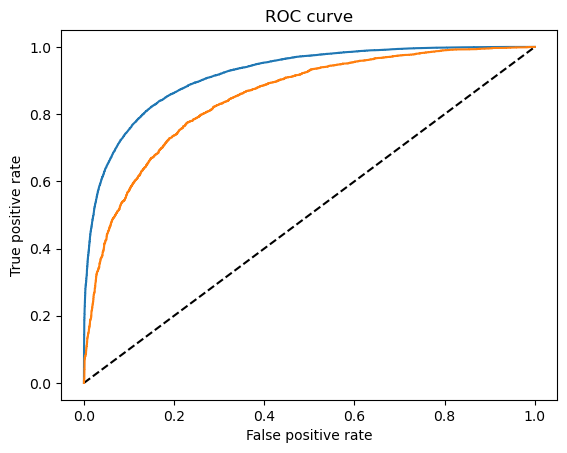

In [47]:
def plot_classifier(clf, X_train, y_train, X_test, y_test, metric):    
    
    y_pred_train = clf.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train)
    
    y_pred_test = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_test)
    
    plt.plot([0, 1], [0, 1], 'k--', label='Coin Flip')
    plt.plot(fpr_train, tpr_train, label='Training Data')
    plt.plot(fpr, tpr, label='Testing Data')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    
    
     
    print(f'Train AUC: {roc_auc_score(y_train, y_pred_train)}, Train F1 Score: {f1_score(y_train, y_pred_train.round())}')
    print(f'Test AUC: {roc_auc_score(y_test, y_pred_test)}, Test F1 Score: {f1_score(y_test, y_pred_test.round())}')
    print(f'Test Accuracy: {accuracy_score(y_test, metric(X_test))}')
# Out of the box, the XGBoost classifier model has a 78% accuracy on the test set.

plot_classifier(clf, X_train_scaled, y_train, X_test_scaled, y_test, clf.predict)

In [49]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
[(COLUMNS[i], importances[i]) for i in indices]

[("city_King's Landing", 0.3170738),
 ('phone_Android', 0.14805591),
 ('avg_rating_by_driver', 0.1347797),
 ('ultimate_black_user', 0.09787529),
 ('city_Astapor', 0.07181045),
 ('weekday_pct', 0.049537934),
 ('avg_surge', 0.047050286),
 ('surge_pct', 0.046260107),
 ('trips_in_first_30_days', 0.029709214),
 ('avg_rating_of_driver', 0.02196186),
 ('avg_dist', 0.019659521),
 ('city_Winterfell', 0.016225953),
 ('phone_iPhone', 0.0)]

Ultimate can leverage insights from the model by focusing retention efforts on key factors like city-specific engagement and platform usability as the two most significant features in the XGBoost model were the user's city and phone model. It would be valuable to investigate why users from King's Landing are more likely to stay active. Additionally, it appears that Android users are much less likely to remain active. I recommend examining the differences between the Android and iPhone apps to determine if any usability improvements are needed.Tailoring solutions to these insights will allow Ultimate to address the specific needs of different user groups, improving overall rider retention.